JUPYTER PYTHON EXE: /Users/songye03/miniconda3/envs/jstreet/bin/python 

TERMINAL PYTHON EXE: /Users/songye03/miniconda3/envs/jstreet/bin/python 

TERMINAL PIP EXE: /Users/songye03/miniconda3/envs/jstreet/bin/pip 



In [39]:
import numpy as np
import pandas as pd

np.random.seed(0)

# Parameters
n_ticks = 20_000
start = pd.Timestamp("2024-01-02 09:30:00")
freq = "100ms"            # one tick every 0.1s

# Time index
ts = pd.date_range(start=start, periods=n_ticks, freq=freq)

# Simulate a midprice as a random walk
mid = 100 + np.cumsum(0.001 * np.random.randn(n_ticks))

# Simulate a small positive spread with some randomness
spread = 0.01 + 0.01 * np.abs(np.random.randn(n_ticks))
bid = mid - spread / 2
ask = mid + spread / 2

# Simulate sizes
bid_size = np.random.randint(10, 200, size=n_ticks)
ask_size = np.random.randint(10, 200, size=n_ticks)

# Simulate trades: only some ticks have trades
trade_mask = np.random.rand(n_ticks) < 0.15    # 15% of ticks have a trade
last_price = np.where(trade_mask,
                      mid + 0.005 * np.random.randn(n_ticks),  # small noise around mid
                      np.nan)
last_size = np.where(trade_mask,
                     np.random.randint(1, 500, size=n_ticks),
                     0)


df = pd.DataFrame({
    "timestamp": ts,
    "bid": bid,
    "ask": ask,
    "bid_size": bid_size,
    "ask_size": ask_size,
    "last_price": last_price,
    "last_size": last_size,
})

# Set index to timestamp (typical in time-series work)
df = df.set_index("timestamp").sort_index()

df.head()

df["mid"] = (df["bid"] + df["ask"]) / 2
# resample output
df_resampled = df.resample("1S").agg({
    "bid": "last",
    "ask": "last",
    "bid_size": "sum",
    "ask_size": "sum",
    "last_price": "last",
    "last_size": "sum",
    "mid": "last",
})

df_resampled = df_resampled.dropna().copy()
df_resampled.head()

df_resampled["return"] = df_resampled["mid"].pct_change()
# volatility as rolling std of returns
df_resampled["volatility"] = df_resampled["return"].rolling(window=10).std() * np.sqrt(10)
# imbalance
df_resampled["imbalance"] = (df_resampled["bid_size"] - df_resampled["ask_size"]) / (df_resampled["bid_size"] + df_resampled["ask_size"])

df_resampled.head()

/var/folders/4j/c4pgfv0n7b7fjqxpbfkdnz440000gn/T/ipykernel_28952/704464988.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_resampled = df.resample("1S").agg({


,bid,ask,bid_size,ask_size,last_price,last_size,mid,return,volatility,imbalance
timestamp,,,,,,,,,,
2024-01-02 09:30:01,100.005367,100.017407,1003,920,100.004982,297,100.011387,NaN,NaN,0.043162
2024-01-02 09:30:02,100.001769,100.024803,1196,1121,100.008580,65,100.013286,0.000019,NaN,0.032369
2024-01-02 09:30:04,99.999602,100.014454,926,866,100.001305,4,100.007028,-0.000063,NaN,0.033482
2024-01-02 09:30:05,99.996855,100.012345,669,737,100.002817,147,100.004600,-0.000024,NaN,-0.048364
2024-01-02 09:30:06,99.991834,100.005729,1131,1297,99.997375,230,99.998781,-0.000058,NaN,-0.068369


[nan nan nan ... -1. -1. -1.]
Sharpe (per period): 0.01719197668318755
Max drawdown: -0.0012658839312943426
20657


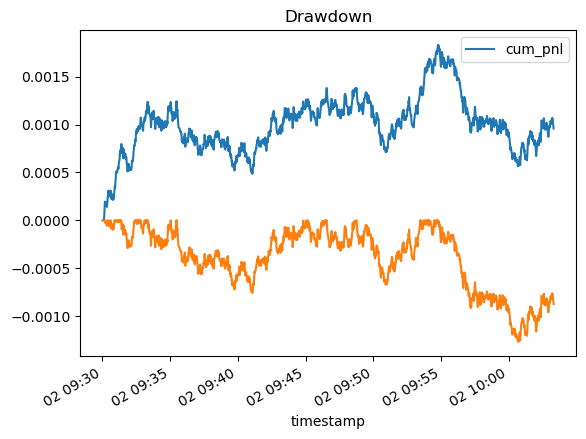

In [40]:

# 1. Define position: +1 if imbalance > 0.6, -1 if < -0.6, otherwise hold previous, start at 0.
raw_pos = np.where(
    df_resampled["imbalance"] > 0.05,  1,
    np.where(df_resampled["imbalance"] < -0.05, -1, np.nan)
)

print(raw_pos)

pos = pd.Series(raw_pos, index=df_resampled.index)
pos = pos.ffill().fillna(0)   # carry last non-NaN forward, start from 0

df_resampled["position"] = pos

# 2. Compute P&L per period
# Use previous period's position times current return, to avoid look-ahead bias.
ret = df_resampled["return"].fillna(0)
pos_prev = df_resampled["position"].shift(1).fillna(0)

df_resampled["pnl"] = pos_prev * ret   # if you want notional N, multiply here: N * pos_prev * ret

# 3. Cumulative P&L
df_resampled["cum_pnl"] = df_resampled["pnl"].cumsum()

# 4. Sharpe ratio (no annualization, just mean / std of per-period P&L)
pnl_mean = df_resampled["pnl"].mean()
pnl_std = df_resampled["pnl"].std()

sharpe = pnl_mean / pnl_std if pnl_std != 0 else np.nan

# 5. Drawdown
cum = df_resampled["cum_pnl"]
roll_max = cum.cummax()
drawdown = cum - roll_max          # <= 0
max_drawdown = drawdown.min()      # most negative drawdown

print("Sharpe (per period):", sharpe)
print("Max drawdown:", max_drawdown)

df_resampled[["cum_pnl"]].plot(title="Cumulative P&L")
drawdown.plot(title="Drawdown")
df_resampled.head(100)
print(df_resampled.size)